In [ ]:
import pandas as pd
import numpy as np
from hpelm import ELM
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import itertools

df = pd.read_excel('final_dataset.xlsx')

drop_columns = ["Seli", "mccinfo", "Şehir", "İlçe"]
df = df.drop(columns=drop_columns)


cols_to_convert = [
    "bıst100_Şimdi", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Şimdi", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Şimdi", "USD_Açılış", "USD_Yüksek", "USD_Düşük"
]

def turkish_str_to_float(x):
    if isinstance(x, str):
        x = x.replace('.', '').replace(',', '.')
    try:
        return float(x)
    except:
        return None

for col in cols_to_convert:
    df[col] = df[col].apply(turkish_str_to_float)

df = df.drop(columns=["Tarih"])

# Hedef değişken ve özellikler
target_col = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target_col])
y = df[target_col].values


In [ ]:


feature_names = X.columns


selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)


selected_features = feature_names[selector.get_support()]
print("Seçilen Özellikler:", list(selected_features))

# Grid search ve model eğitimi için X_new'i numpy array'e çeviriyoruz.
X_new = X_new.astype(float)

# --- Hiperparametre Ayarlaması için Grid Search ---
param_grid = {
    'n_hidden': [25, 50, 100, 200, 300],
    'activation': ['sigm', 'tanh']
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

best_r2 = -np.inf
best_params = None
results = []


Seçilen Özellikler: ['basarili_satis_adet', 'basarili_satis_ciro', 'basarili_iade_adet', 'basarili_iade_ciro', 'Müşteri Skoru', 'Euro_Şimdi', 'Euro_Açılış', 'Euro_Yüksek', 'USD_Açılış', 'USD_Düşük']


In [ ]:

# Grid Search: Her kombinasyon için cross validation uyguluyoruz.
for n_hidden, activation in itertools.product(param_grid['n_hidden'], param_grid['activation']):
    mae_list, mape_list, r2_list = [], [], []
    
    for train_index, test_index in kf.split(X_new):
        X_train, X_test = X_new[train_index], X_new[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # ELM modeli
        elm = ELM(X_train.shape[1], 1)
        elm.add_neurons(n_hidden, activation)
        
        # Regresyon modunda modeli eğitiyoruz ('r')
        elm.train(X_train, y_train.reshape(-1, 1), 'r')
        
        # Tahminler
        y_pred = elm.predict(X_test).ravel()
        
        # Metrikleri 
        mae_list.append(mean_absolute_error(y_test, y_pred))
        mape_list.append(mean_absolute_percentage_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))
    
    
    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)
    avg_r2 = np.mean(r2_list)
    
    results.append({
        'n_hidden': n_hidden,
        'activation': activation,
        'MAE': avg_mae,
        'MAPE': avg_mape,
        'R2': avg_r2
    })
    
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_params = {'n_hidden': n_hidden, 'activation': activation}

print("Grid Search Sonuçları:")
for res in results:
    print(res)



# --- Final Regresyon Modeli (En iyi parametrelerle) ---
all_y_true = np.zeros_like(y)
all_y_pred = np.zeros_like(y)

for train_index, test_index in kf.split(X_new):
    X_train, X_test = X_new[train_index], X_new[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    elm = ELM(X_train.shape[1], 1)
    elm.add_neurons(best_params['n_hidden'], best_params['activation'])
    elm.train(X_train, y_train.reshape(-1, 1), 'r')
    
    y_pred_fold = elm.predict(X_test).ravel()
    
    all_y_true[test_index] = y_test
    all_y_pred[test_index] = y_pred_fold


print("\nEn iyi parametreler:")

print("MAE:", avg_mae)
print("MAPE:", avg_mape)
print("R2:", best_r2)

c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\hpelm\nnets\slfn.py:62: RuntimeWarning: overflow encountered in exp
  self.func["sigm"] = lambda X, W, B: 1 / (1 + np.exp(np.dot(X, W) + B))


Grid Search Sonuçları:
{'n_hidden': 25, 'activation': 'sigm', 'MAE': 0.5286040249723412, 'MAPE': 0.1340949651137975, 'R2': 0.14372829487668523}
{'n_hidden': 25, 'activation': 'tanh', 'MAE': 0.6181573522299653, 'MAPE': 0.15432340766693103, 'R2': -0.216824859160384}
{'n_hidden': 50, 'activation': 'sigm', 'MAE': 0.5144431123808242, 'MAPE': 0.12771669603875666, 'R2': 0.168668732778766}
{'n_hidden': 50, 'activation': 'tanh', 'MAE': 0.5503423684918481, 'MAPE': 0.13629641737167156, 'R2': 0.037823798588806336}
{'n_hidden': 100, 'activation': 'sigm', 'MAE': 0.5781691758701606, 'MAPE': 0.1473133940867576, 'R2': -1.0759621049539614}
{'n_hidden': 100, 'activation': 'tanh', 'MAE': 0.5414843033988914, 'MAPE': 0.13801522034940064, 'R2': -0.3265501373508189}
{'n_hidden': 200, 'activation': 'sigm', 'MAE': 0.9734486321789685, 'MAPE': 0.2652588781695555, 'R2': -50.863114869787466}
{'n_hidden': 200, 'activation': 'tanh', 'MAE': 0.5769738539855467, 'MAPE': 0.1481117632350624, 'R2': -0.8418774482144376}
{'n

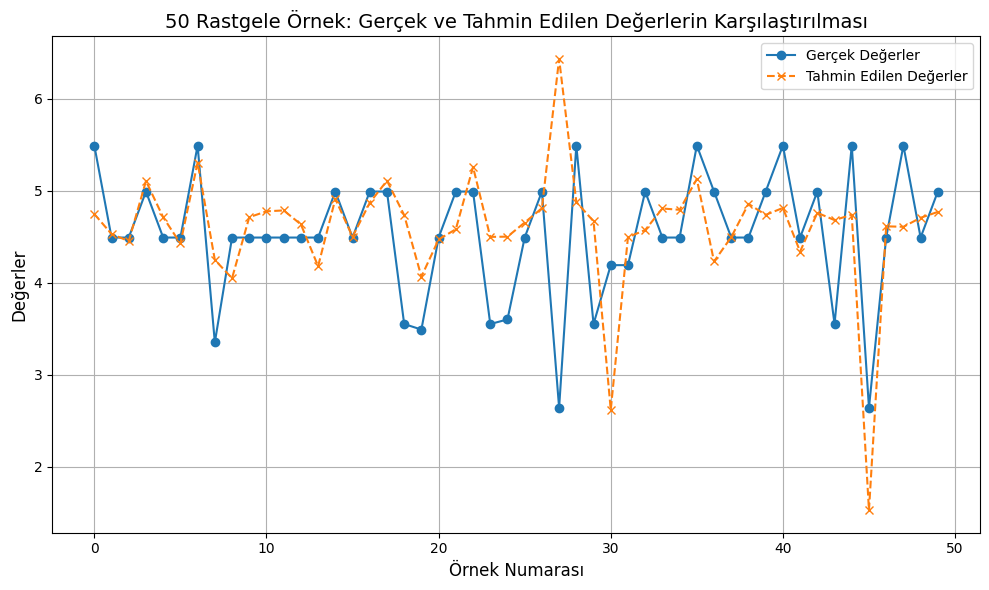

In [12]:
np.random.seed(42)
total_samples = len(all_y_true)
random_indices = np.random.choice(total_samples, size=50, replace=False)

sample_true = all_y_true[random_indices]
sample_pred = all_y_pred[random_indices]

sample_index = np.arange(len(sample_true))

plt.figure(figsize=(10, 6))
plt.plot(sample_index, sample_true, label="Gerçek Değerler", marker='o', linestyle='-', markersize=6)
plt.plot(sample_index, sample_pred, label="Tahmin Edilen Değerler", marker='x', linestyle='--', markersize=6)

plt.xlabel("Örnek Numarası", fontsize=12)
plt.ylabel("Değerler", fontsize=12)
plt.title("50 Rastgele Örnek: Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


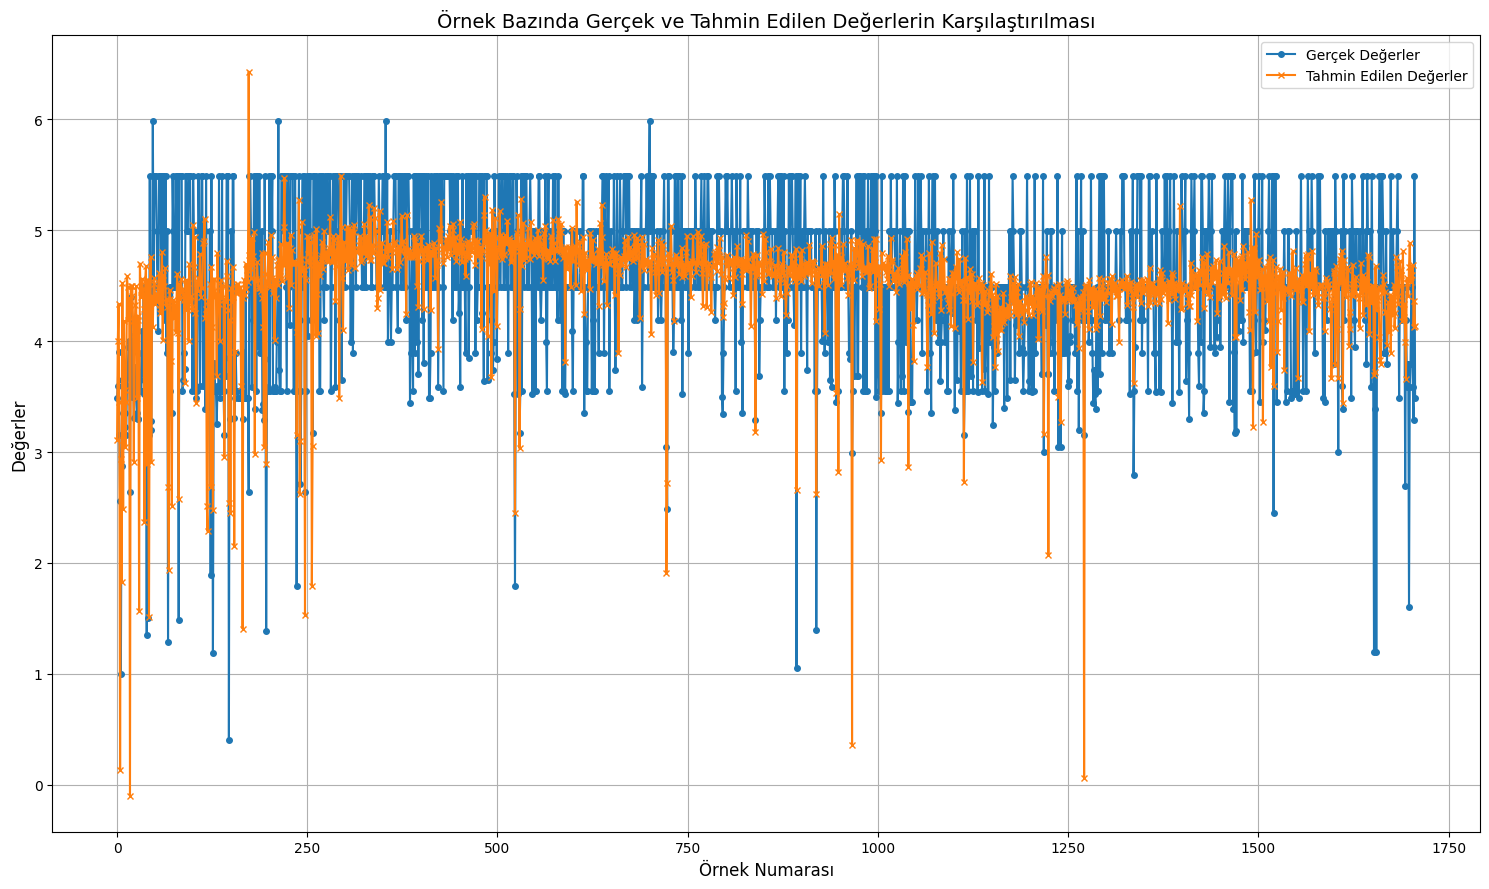

In [13]:
# --- Tahmin ve Gerçek Değerlerin Grafiksel Gösterimi (Örnek Bazında) ---
plt.figure(figsize=(15,9), dpi=100)
# Örnek numarası x ekseninde
sample_index = range(len(all_y_true))

# Gerçek değerler ve tahmin edilen değerleri çiziyoruz.
plt.plot(sample_index, all_y_true, label="Gerçek Değerler", marker='o', linestyle='-', markersize=4)
plt.plot(sample_index, all_y_pred, label="Tahmin Edilen Değerler", marker='x', linestyle='-', markersize=4)

plt.xlabel("Örnek Numarası", fontsize=12)
plt.ylabel("Değerler", fontsize=12)
plt.title("Örnek Bazında Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
